# Full Cross-Validation and Final Training Evaluation Workflow

This repository contains a Jupyter Notebook that implements a complete workflow for training, evaluating, and visualizing the performance of a **Graph Attention Network (GAT)** for graph-based regression or classification tasks. The workflow includes cross-validation, hyperparameter tuning, ensemble averaging, and final model evaluation.

---

## 📋 Workflow Overview

### 1. **Imports and Setup**
- Load essential libraries: PyTorch, PyTorch Geometric, scikit-learn, and matplotlib.
- Configure plotting and file management tools.

### 2. **Task and Reproducibility Setup**
- Define the task: `classification` or `regression`.
- Set a fixed random seed for reproducibility.
- Specify class names (for classification) and configure result directories.

### 3. **Model Definition**
- Define an **GAT Model**
- The model processes node and edge features and outputs predictions.

### 4. **Evaluation Helper Function**
- Implements an `evaluate(model, loader)` function to compute predictions and ground truths for a given dataset.

### 5. **Input Dimensions and Device Setup**
- Automatically determine input feature dimensions from the dataset.
- Detect and assign the appropriate device (CPU or GPU).

### 6. **Hyperparameter Tuning**
- Perform a grid search over hyperparameters:
    - Hidden dimensions
    - Dropout rates
    - Learning rates
- Train and validate the model across multiple folds, logging metrics for each configuration.

### 7. **Cross-Validation Training**
- Train the model across 10 folds using pre-split datasets.
- Log metrics for each fold:
    - **Regression**: MAE, MSE, RMSE, R²
    - **Classification**: Accuracy, Precision, Recall, F1, AUC-ROC
- Save fold-wise results to a CSV file.

### 8. **Ensemble Averaging**
- Combine predictions from all fold models using ensemble averaging.
- Evaluate the ensemble on the test set and compute metrics.

### 9. **Final Model Training**
- Merge all training and validation folds into a single dataset.
- Reserve a small validation split for early stopping.
- Train the final model with:
    - Early stopping (based on validation loss)
    - Learning rate scheduler
    - Model checkpointing (saves the best model)
- Evaluate the final model on the test set.

### 10. **Visualization**
- Generate plots for:
    - Cross-validation metrics (e.g., MAE, MSE, RMSE, R² per fold)
    - Ensemble predictions vs. true values
    - Final model predictions vs. true values
- Save plots and metrics to the results directory.

---

## 📊 Outputs
1. **Cross-Validation Results**:
     - Fold-wise metrics saved to `crossval_summary.csv`.
     - Bar charts for fold-wise metrics.
     - Mean ± standard deviation summary.

2. **Ensemble Results**:
     - Ensemble predictions and metrics.
     - Scatter plot of ensemble predictions vs. true values.

3. **Final Model Results**:
     - Final model predictions and metrics.
     - Scatter plot of final model predictions vs. true values.
     - Saved final model weights.

---

## 🚀 How to Run
1. Ensure all dependencies are installed:
     - PyTorch, PyTorch Geometric, scikit-learn, matplotlib, numpy, pandas.
2. Prepare your dataset in the required format (node features, edge features, labels).
3. Configure the task (`classification` or `regression`) and hyperparameters in the notebook.
4. Execute the notebook step-by-step to train, evaluate, and visualize the model.

---



## 1. Imports and Setup

In [1]:
import torch
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import random

/Users/yao/Desktop/venv1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Task and Reproducibility Setup

In [15]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

#task = "classification"  # or "regression"
task = "regression"  # or "classification"
num_classes = 3
class_names = {0: "Low", 1: "Medium", 2: "High"}
kfold = 10
base_path = f"../4_train_test_split/10fold_cv/{task}/"
results_dir = f"GAT_results/{task}_{kfold}fold/"
os.makedirs(results_dir, exist_ok=True)

## 3. Define GAT model

In [3]:
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout, heads=8):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.lin = Linear(hidden_channels * heads, out_channels)
        
    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x, batch)  # Aggregate node features to graph level
        return self.lin(x)

## 4. Evaluation Helper Function

In [4]:
def evaluate(model, loader):
    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            preds.append(out.cpu())
            labels.append(batch.y.cpu())
    return torch.cat(preds), torch.cat(labels)

## 5. Input Dimensions and Device Setup

In [6]:
sample_data = torch.load(os.path.join(base_path, f"{task}_train_fold0.pt"))[0]
input_dim = sample_data.x.size(1)
edge_dim = sample_data.edge_attr.size(1)
output_dim = num_classes if task == "classification" else 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/1340473836.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sample_data = torch.load(os.path.join(base_pa

## 6: Hyperparameter Tuning

In [12]:
# Hyperparameter grids
# hidden_dims = [64, 128, 256]
# dropouts = [0.0, 0.2, 0.4]
# lrs = [1e-3, 5e-4, 1e-4]

hidden_dims = [64]
dropouts = [0.4]
lrs = [1e-3]

results = []
print("Starting hyperparameter sweep over hidden_dim, dropout, and learning rate")
for hd in hidden_dims:
    for dp in dropouts:
        for lr in lrs:
            print(f"Config: hidden_dim={hd}, dropout={dp}, lr={lr}")
            fold_metrics = []
            for fold in range(10):
                # Load fold data
                train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
                val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

                # Initialize model and optimizer
                model = GAT(in_channels=input_dim, hidden_channels=hd,
                            out_channels=output_dim, heads=1, dropout=dp).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                # Data loaders
                train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
                val_loader   = DataLoader(val_data,   batch_size=32)

                # Training loop
                for epoch in range(1, 51):
                    model.train()
                    for batch in train_loader:
                        batch = batch.to(device)
                        optimizer.zero_grad()
                        out = model(batch)
                        loss = F.mse_loss(out.squeeze(), batch.y)
                        loss.backward()
                        optimizer.step()

                # Validation
                preds, trues = evaluate(model, val_loader)
                y_true = trues.numpy()
                y_pred = preds.squeeze().numpy()
                r2 = r2_score(y_true, y_pred)
                fold_metrics.append(r2)

            # Record mean and std
            mean_r2 = np.mean(fold_metrics)
            std_r2  = np.std(fold_metrics)
            results.append((hd, dp, lr, mean_r2, std_r2))
            print(f"📊 R²: {mean_r2:.4f} ± {std_r2:.4f}")

# Compile results into DataFrame
sweep_df = pd.DataFrame(results,
                        columns=["hidden_dim", "dropout", "learning_rate", "mean_r2", "std_r2"])
# Display sorted by best performance
display(sweep_df.sort_values("mean_r2", ascending=False))
cv_df = pd.DataFrame(fold_metrics)


Starting hyperparameter sweep over hidden_dim, dropout, and learning rate
Config: hidden_dim=64, dropout=0.4, lr=0.001


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/1326681047.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pa

📊 R²: -0.4170 ± 0.4276


,hidden_dim,dropout,learning_rate,mean_r2,std_r2
0,64,0.4,0.001,-0.416961,0.42758


## select best hyperparameters

In [14]:

# %% to change later
best_heads = 4
best_hidden_dim = 64
best_dropout = 0.2
best_lr = 0.001

## 7: Retrain All Folds with Best Hyperparameters

In [17]:

# %%
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score
)
import pandas as pd

fold_metrics = []

for fold in range(10):
    print(f"\n🔁 Retraining Fold {fold+1}/10 with best hyperparameters")
    train_data = torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    val_data   = torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

    model = GAT(in_channels=input_dim, hidden_channels=best_hidden_dim,
            out_channels=output_dim, heads=best_heads, dropout=best_dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_data,   batch_size=32)

    best_val_loss = float('inf')
    patience = 0

    # Training loop with early stopping
    for epoch in range(1, 301):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = (F.cross_entropy(out, batch.y.long())
                    if task=="classification"
                    else F.mse_loss(out.squeeze(), batch.y))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate on validation
        preds, targets = evaluate(model, val_loader)
        val_loss = (F.cross_entropy(preds, targets.long()).item()
                    if task=="classification"
                    else F.mse_loss(preds.squeeze(), targets).item())

        print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

        # Save best
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience = 0
            torch.save(model.state_dict(),
                       os.path.join(results_dir, f"fold{fold+1}_model.pt"))
        else:
            patience += 1
            if patience >= 10:
                print("⏹️ Early stopping")
                break

    # --- After training this fold, compute metrics on its validation set ---
    preds_np = preds.squeeze().cpu().numpy()
    trues_np = targets.cpu().numpy()

    if task == "classification":
        from sklearn.metrics import (
            accuracy_score,
            precision_recall_fscore_support,
            roc_auc_score
        )
        y_true = trues_np.astype(int)
        y_probs = F.softmax(preds, dim=1).cpu().numpy()
        y_pred  = preds.argmax(dim=1).cpu().numpy()

        acc = accuracy_score(y_true, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(
            y_true, y_pred, average="weighted", zero_division=0)
        auc = roc_auc_score(
            label_binarize(y_true, classes=np.arange(num_classes)),
            y_probs, multi_class="ovr")

        fold_metrics.append({
            "fold": fold+1,
            "accuracy": acc,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "auc_roc": auc
        })
    else:  # regression
        mae  = mean_absolute_error(trues_np, preds_np)
        mse  = mean_squared_error(trues_np, preds_np)
        rmse = np.sqrt(mse)
        r2   = r2_score(trues_np, preds_np)

        fold_metrics.append({
            "fold": fold+1,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "r2": r2
        })

# --- Save the cross-validation summary ---
cv_df = pd.DataFrame(fold_metrics)
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df.to_csv(cv_path, index=False)
print(f"✅ Saved cross‑validation summary to {cv_path}")



🔁 Retraining Fold 1/10 with best hyperparameters


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 18.2448 | Val Loss: 2.2863
Epoch 002 | Train Loss: 2.9034 | Val Loss: 1.3822
Epoch 003 | Train Loss: 1.6280 | Val Loss: 1.3572
Epoch 004 | Train Loss: 1.3386 | Val Loss: 1.1876
Epoch 005 | Train Loss: 1.3252 | Val Loss: 1.3020
Epoch 006 | Train Loss: 1.2673 | Val Loss: 1.1552
Epoch 007 | Train Loss: 1.3313 | Val Loss: 1.2925
Epoch 008 | Train Loss: 1.2712 | Val Loss: 1.1341
Epoch 009 | Train Loss: 1.3829 | Val Loss: 1.1821
Epoch 010 | Train Loss: 1.3124 | Val Loss: 1.2522
Epoch 011 | Train Loss: 1.2449 | Val Loss: 1.1341
Epoch 012 | Train Loss: 1.2319 | Val Loss: 1.0776
Epoch 013 | Train Loss: 1.1814 | Val Loss: 1.1102
Epoch 014 | Train Loss: 1.2266 | Val Loss: 1.0708
Epoch 015 | Train Loss: 1.0682 | Val Loss: 1.3027
Epoch 016 | Train Loss: 1.2715 | Val Loss: 1.0123
Epoch 017 | Train Loss: 1.1707 | Val Loss: 1.0179
Epoch 018 | Train Loss: 1.1497 | Val Loss: 1.0289
Epoch 019 | Train Loss: 1.1447 | Val Loss: 0.9667
Epoch 020 | Train Loss: 1.2508 | Val Loss: 0.9352

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 22.8063 | Val Loss: 1.3115
Epoch 002 | Train Loss: 3.2188 | Val Loss: 1.2276
Epoch 003 | Train Loss: 1.8710 | Val Loss: 1.1415
Epoch 004 | Train Loss: 1.4529 | Val Loss: 1.1251
Epoch 005 | Train Loss: 1.2236 | Val Loss: 1.1146
Epoch 006 | Train Loss: 1.2867 | Val Loss: 1.1095
Epoch 007 | Train Loss: 1.2570 | Val Loss: 1.0975
Epoch 008 | Train Loss: 1.1631 | Val Loss: 1.0809
Epoch 009 | Train Loss: 1.2579 | Val Loss: 1.0809
Epoch 010 | Train Loss: 1.0942 | Val Loss: 1.0575
Epoch 011 | Train Loss: 1.2360 | Val Loss: 1.0950
Epoch 012 | Train Loss: 1.1981 | Val Loss: 1.0398
Epoch 013 | Train Loss: 1.1378 | Val Loss: 1.0325
Epoch 014 | Train Loss: 1.1006 | Val Loss: 1.0770
Epoch 015 | Train Loss: 1.0908 | Val Loss: 1.0200
Epoch 016 | Train Loss: 1.0752 | Val Loss: 1.0106
Epoch 017 | Train Loss: 1.1424 | Val Loss: 1.0055
Epoch 018 | Train Loss: 1.1272 | Val Loss: 1.0118
Epoch 019 | Train Loss: 1.1012 | Val Loss: 1.0032
Epoch 020 | Train Loss: 1.1288 | Val Loss: 0.9973

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 17.9647 | Val Loss: 1.4181
Epoch 002 | Train Loss: 3.7715 | Val Loss: 3.9280
Epoch 003 | Train Loss: 2.0991 | Val Loss: 1.7353
Epoch 004 | Train Loss: 1.6868 | Val Loss: 2.4266
Epoch 005 | Train Loss: 1.4762 | Val Loss: 1.7535
Epoch 006 | Train Loss: 1.3163 | Val Loss: 2.0765
Epoch 007 | Train Loss: 1.2128 | Val Loss: 1.6845
Epoch 008 | Train Loss: 1.2564 | Val Loss: 1.5167
Epoch 009 | Train Loss: 1.1875 | Val Loss: 1.7061
Epoch 010 | Train Loss: 1.2310 | Val Loss: 1.6685
Epoch 011 | Train Loss: 1.2310 | Val Loss: 1.8794
⏹️ Early stopping

🔁 Retraining Fold 4/10 with best hyperparameters
Epoch 001 | Train Loss: 24.6801 | Val Loss: 2.1316


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 002 | Train Loss: 3.3199 | Val Loss: 1.5754
Epoch 003 | Train Loss: 2.0147 | Val Loss: 1.4104
Epoch 004 | Train Loss: 1.5310 | Val Loss: 1.2774
Epoch 005 | Train Loss: 1.5534 | Val Loss: 1.1867
Epoch 006 | Train Loss: 1.2995 | Val Loss: 1.2550
Epoch 007 | Train Loss: 1.2914 | Val Loss: 1.0588
Epoch 008 | Train Loss: 1.2677 | Val Loss: 1.0944
Epoch 009 | Train Loss: 1.1746 | Val Loss: 1.0580
Epoch 010 | Train Loss: 1.1891 | Val Loss: 1.0699
Epoch 011 | Train Loss: 1.1929 | Val Loss: 1.0527
Epoch 012 | Train Loss: 1.1267 | Val Loss: 1.1146
Epoch 013 | Train Loss: 1.1565 | Val Loss: 0.9695
Epoch 014 | Train Loss: 1.1297 | Val Loss: 0.9438
Epoch 015 | Train Loss: 1.0922 | Val Loss: 0.9054
Epoch 016 | Train Loss: 1.1419 | Val Loss: 0.9119
Epoch 017 | Train Loss: 1.0929 | Val Loss: 0.9124
Epoch 018 | Train Loss: 1.0470 | Val Loss: 0.9631
Epoch 019 | Train Loss: 1.0939 | Val Loss: 1.0782
Epoch 020 | Train Loss: 1.0586 | Val Loss: 0.8679
Epoch 021 | Train Loss: 1.1464 | Val Loss: 0.8600


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 17.7416 | Val Loss: 3.1589
Epoch 002 | Train Loss: 2.9684 | Val Loss: 2.0268
Epoch 003 | Train Loss: 1.7891 | Val Loss: 1.4449
Epoch 004 | Train Loss: 1.4712 | Val Loss: 1.3778
Epoch 005 | Train Loss: 1.3531 | Val Loss: 1.2810
Epoch 006 | Train Loss: 1.3664 | Val Loss: 1.2094
Epoch 007 | Train Loss: 1.2709 | Val Loss: 1.2245
Epoch 008 | Train Loss: 1.2469 | Val Loss: 1.1431
Epoch 009 | Train Loss: 1.2608 | Val Loss: 1.1023
Epoch 010 | Train Loss: 1.2042 | Val Loss: 1.0135
Epoch 011 | Train Loss: 1.2199 | Val Loss: 1.0159
Epoch 012 | Train Loss: 1.1915 | Val Loss: 0.9532
Epoch 013 | Train Loss: 1.1626 | Val Loss: 0.9507
Epoch 014 | Train Loss: 1.0805 | Val Loss: 0.9213
Epoch 015 | Train Loss: 1.1740 | Val Loss: 0.9043
Epoch 016 | Train Loss: 1.1517 | Val Loss: 0.9056
Epoch 017 | Train Loss: 1.1908 | Val Loss: 0.8892
Epoch 018 | Train Loss: 1.1139 | Val Loss: 0.9202
Epoch 019 | Train Loss: 1.0838 | Val Loss: 0.8752
Epoch 020 | Train Loss: 1.0301 | Val Loss: 0.9741

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 23.2398 | Val Loss: 1.8819
Epoch 002 | Train Loss: 2.8031 | Val Loss: 1.3415
Epoch 003 | Train Loss: 1.7811 | Val Loss: 1.1979
Epoch 004 | Train Loss: 1.3972 | Val Loss: 1.2541
Epoch 005 | Train Loss: 1.3255 | Val Loss: 1.1319
Epoch 006 | Train Loss: 1.2576 | Val Loss: 1.2118
Epoch 007 | Train Loss: 1.2725 | Val Loss: 1.1384
Epoch 008 | Train Loss: 1.2139 | Val Loss: 1.0995
Epoch 009 | Train Loss: 1.2042 | Val Loss: 1.1382
Epoch 010 | Train Loss: 1.2185 | Val Loss: 1.1570
Epoch 011 | Train Loss: 1.1547 | Val Loss: 1.1106
Epoch 012 | Train Loss: 1.1840 | Val Loss: 1.0844
Epoch 013 | Train Loss: 1.1713 | Val Loss: 1.0769
Epoch 014 | Train Loss: 1.1216 | Val Loss: 1.1528
Epoch 015 | Train Loss: 1.1474 | Val Loss: 1.1350
Epoch 016 | Train Loss: 1.0613 | Val Loss: 1.0140
Epoch 017 | Train Loss: 1.0331 | Val Loss: 1.0681
Epoch 018 | Train Loss: 1.0563 | Val Loss: 1.0685
Epoch 019 | Train Loss: 1.1210 | Val Loss: 0.9914
Epoch 020 | Train Loss: 1.0306 | Val Loss: 1.1042

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 002 | Train Loss: 2.9335 | Val Loss: 1.5588
Epoch 003 | Train Loss: 1.4394 | Val Loss: 1.2673
Epoch 004 | Train Loss: 1.3418 | Val Loss: 1.2570
Epoch 005 | Train Loss: 1.2578 | Val Loss: 1.2105
Epoch 006 | Train Loss: 1.2899 | Val Loss: 1.2001
Epoch 007 | Train Loss: 1.2107 | Val Loss: 1.1716
Epoch 008 | Train Loss: 1.1345 | Val Loss: 1.1630
Epoch 009 | Train Loss: 1.1933 | Val Loss: 1.1553
Epoch 010 | Train Loss: 1.1639 | Val Loss: 1.1596
Epoch 011 | Train Loss: 1.1726 | Val Loss: 1.1465
Epoch 012 | Train Loss: 1.1352 | Val Loss: 1.1758
Epoch 013 | Train Loss: 1.0525 | Val Loss: 1.1440
Epoch 014 | Train Loss: 1.0823 | Val Loss: 1.1311
Epoch 015 | Train Loss: 1.0716 | Val Loss: 1.1336
Epoch 016 | Train Loss: 0.9770 | Val Loss: 1.2677
Epoch 017 | Train Loss: 1.0765 | Val Loss: 1.2664
Epoch 018 | Train Loss: 1.1262 | Val Loss: 1.2065
Epoch 019 | Train Loss: 1.0904 | Val Loss: 1.1383
Epoch 020 | Train Loss: 1.0311 | Val Loss: 1.1485
Epoch 021 | Train Loss: 1.1057 | Val Loss: 1.1554


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 21.9911 | Val Loss: 1.3327
Epoch 002 | Train Loss: 3.6786 | Val Loss: 1.8385
Epoch 003 | Train Loss: 1.9587 | Val Loss: 1.1258
Epoch 004 | Train Loss: 1.5081 | Val Loss: 1.2206
Epoch 005 | Train Loss: 1.4070 | Val Loss: 1.0069
Epoch 006 | Train Loss: 1.3937 | Val Loss: 1.2324
Epoch 007 | Train Loss: 1.2144 | Val Loss: 0.9481
Epoch 008 | Train Loss: 1.2624 | Val Loss: 0.9777
Epoch 009 | Train Loss: 1.2100 | Val Loss: 0.9576
Epoch 010 | Train Loss: 1.2217 | Val Loss: 0.9291
Epoch 011 | Train Loss: 1.1419 | Val Loss: 0.9078
Epoch 012 | Train Loss: 1.1231 | Val Loss: 1.0631
Epoch 013 | Train Loss: 1.2258 | Val Loss: 1.0103
Epoch 014 | Train Loss: 1.2647 | Val Loss: 0.9467
Epoch 015 | Train Loss: 1.1223 | Val Loss: 0.9380
Epoch 016 | Train Loss: 1.0511 | Val Loss: 0.8353
Epoch 017 | Train Loss: 1.1163 | Val Loss: 0.9218
Epoch 018 | Train Loss: 1.1008 | Val Loss: 1.1023
Epoch 019 | Train Loss: 1.0818 | Val Loss: 0.9247
Epoch 020 | Train Loss: 1.1400 | Val Loss: 0.9206

/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 001 | Train Loss: 25.4701 | Val Loss: 1.8683
Epoch 002 | Train Loss: 3.2093 | Val Loss: 1.2342
Epoch 003 | Train Loss: 1.9009 | Val Loss: 1.2020
Epoch 004 | Train Loss: 1.4707 | Val Loss: 1.1541
Epoch 005 | Train Loss: 1.2420 | Val Loss: 1.1371
Epoch 006 | Train Loss: 1.2059 | Val Loss: 1.1412
Epoch 007 | Train Loss: 1.1397 | Val Loss: 1.1701
Epoch 008 | Train Loss: 1.1322 | Val Loss: 1.1885
Epoch 009 | Train Loss: 1.1538 | Val Loss: 1.1608
Epoch 010 | Train Loss: 1.0951 | Val Loss: 1.1779
Epoch 011 | Train Loss: 1.0667 | Val Loss: 1.1871
Epoch 012 | Train Loss: 1.1072 | Val Loss: 1.1884
Epoch 013 | Train Loss: 1.0657 | Val Loss: 1.2101
Epoch 014 | Train Loss: 1.0823 | Val Loss: 1.2012
Epoch 015 | Train Loss: 1.0735 | Val Loss: 1.2295
⏹️ Early stopping

🔁 Retraining Fold 10/10 with best hyperparameters
Epoch 001 | Train Loss: 22.5210 | Val Loss: 1.8774


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/582034732.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_data = torch.load(os.path.join(base_pat

Epoch 002 | Train Loss: 2.8069 | Val Loss: 1.7275
Epoch 003 | Train Loss: 1.5555 | Val Loss: 1.4914
Epoch 004 | Train Loss: 1.2726 | Val Loss: 1.4757
Epoch 005 | Train Loss: 1.2562 | Val Loss: 1.4596
Epoch 006 | Train Loss: 1.2524 | Val Loss: 1.4392
Epoch 007 | Train Loss: 1.2330 | Val Loss: 1.4389
Epoch 008 | Train Loss: 1.1547 | Val Loss: 1.5083
Epoch 009 | Train Loss: 1.1121 | Val Loss: 1.2788
Epoch 010 | Train Loss: 1.2673 | Val Loss: 1.4038
Epoch 011 | Train Loss: 1.0881 | Val Loss: 1.3375
Epoch 012 | Train Loss: 1.1405 | Val Loss: 1.2699
Epoch 013 | Train Loss: 1.1697 | Val Loss: 1.3001
Epoch 014 | Train Loss: 1.1293 | Val Loss: 1.4794
Epoch 015 | Train Loss: 1.0829 | Val Loss: 1.2973
Epoch 016 | Train Loss: 1.0792 | Val Loss: 1.2043
Epoch 017 | Train Loss: 1.1358 | Val Loss: 1.1919
Epoch 018 | Train Loss: 1.0836 | Val Loss: 1.3288
Epoch 019 | Train Loss: 1.0682 | Val Loss: 1.4045
Epoch 020 | Train Loss: 1.0242 | Val Loss: 1.3576
Epoch 021 | Train Loss: 1.0889 | Val Loss: 1.3478


## 7b: Visualize Cross-Validation Results
## This section plots per-fold metrics from the cross-validation summary to assess stability across folds.


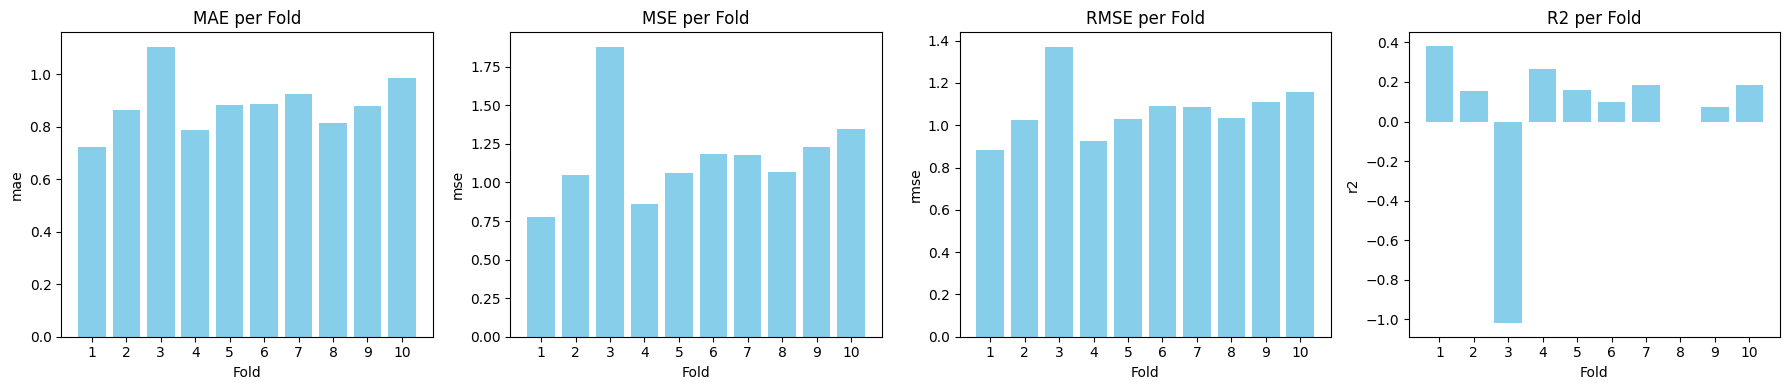

📊 Mean ± Std for Cross-Validation Metrics:


,mean,std
mae,0.8855,0.1061
mse,1.1630,0.3024
rmse,1.0709,0.1338
r2,0.0484,0.3886


In [18]:
# %%
import pandas as pd
import matplotlib.pyplot as plt

# Load summary
cv_path = os.path.join(results_dir, "crossval_summary.csv")
cv_df = pd.read_csv(cv_path)

# Choose metrics
task_metrics = (
    ['accuracy','precision','recall','f1_score','auc_roc']
    if task=="classification"
    else ['mae','mse','rmse','r2']
)

# Plot bar charts per fold
fig, axs = plt.subplots(1, len(task_metrics), figsize=(18, 4))
for i, metric in enumerate(task_metrics):
    axs[i].bar(cv_df['fold'], cv_df[metric], color='skyblue')
    axs[i].set_title(f"{metric.upper()} per Fold")
    axs[i].set_xlabel("Fold")
    axs[i].set_ylabel(metric)
    axs[i].set_xticks(cv_df['fold'])

plt.tight_layout()
plt.show()

# Display mean ± std
summary_stats = cv_df[task_metrics].agg(['mean','std']).T
print("📊 Mean ± Std for Cross-Validation Metrics:")
display(summary_stats.round(4))


## 8a: Ensemble Averaging from Cross-Validation Models

In [19]:
# Load test data
ensemble_preds = []
test_data = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

# Ensure model configuration matches
output_dim = num_classes if task == "classification" else 1

# Collect predictions from each fold model
for fold in range(10):
    model = GAT(in_channels=input_dim, hidden_channels=best_hidden_dim,
            out_channels=output_dim, heads=best_heads, dropout=best_dropout).to(device)
    model.load_state_dict(torch.load(os.path.join(results_dir, f"fold{fold+1}_model.pt")))
    model.eval()
    fold_outputs = []
    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            out = model(batch)
            fold_outputs.append(out.cpu())
    ensemble_preds.append(torch.cat(fold_outputs, dim=0))

# Average predictions across folds
avg_output = torch.stack(ensemble_preds).mean(dim=0)

# Prepare final predictions and true labels
if task == "classification":
    final_pred = avg_output.argmax(dim=1).numpy()
    true_labels = torch.cat([data.y for data in test_data]).numpy().astype(int)
else:
    final_pred = avg_output.squeeze().numpy()
    true_value = torch.cat([data.y for data in test_data]).numpy()

print(f"✅ Ensemble predictions ready: shape {final_pred.shape}")

✅ Ensemble predictions ready: shape (53,)


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/754690304.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load(os.path.join(base_path,

## 8b: Ensemble Evaluation & Visualization


Ensemble: MAE=0.800, RMSE=0.992, R2=0.260


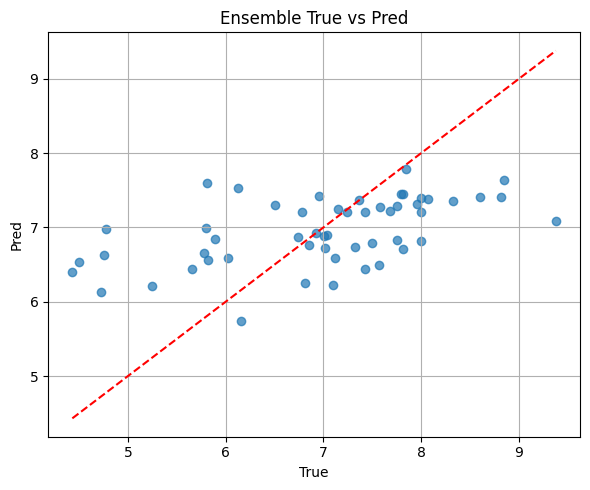

In [20]:


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
mae = mean_absolute_error(true_value, final_pred)
mse = mean_squared_error  (true_value, final_pred)
rmse= np.sqrt(mse)
r2  = r2_score           (true_value, final_pred)
print(f"Ensemble: MAE={mae:.3f}, RMSE={rmse:.3f}, R2={r2:.3f}")
plt.figure(figsize=(6,5)); plt.scatter(true_value,final_pred,alpha=0.7)
plt.plot([true_value.min(),true_value.max()],[true_value.min(),true_value.max()], 'r--'); plt.xlabel("True"); plt.ylabel("Pred"); plt.title("Ensemble True vs Pred"); plt.grid(True); plt.tight_layout(); plt.show()


## 9: Final Model Training on Combined Train+Val & Test Evaluation (Hold‑Out Test)

In [21]:
# %%
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# 1) Merge all train+val folds
all_data = []
for fold in range(10):
    all_data += torch.load(os.path.join(base_path, f"{task}_train_fold{fold}.pt"))
    all_data += torch.load(os.path.join(base_path, f"{task}_val_fold{fold}.pt"))

# 2) Reserve a small val split for early stopping
tidx, vidx = train_test_split(
    list(range(len(all_data))),
    test_size=0.10,
    random_state=seed,
    shuffle=True
)
train_split = [all_data[i] for i in tidx]
val_split   = [all_data[i] for i in vidx]

train_loader = DataLoader(train_split, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_split,   batch_size=32)

# 3) Instantiate & train final model
model = GAT(in_channels=input_dim, hidden_channels=best_hidden_dim,
        out_channels=output_dim, heads=best_heads, dropout=best_dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=best_lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5, verbose=True
)

best_val_loss = float('inf')
patience      = 0

for epoch in range(1, 300):
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = (F.cross_entropy(out, batch.y.long())
                if task == "classification"
                else F.mse_loss(out.squeeze(), batch.y))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation for early stopping
    preds, targets = evaluate(model, val_loader)
    val_loss = (F.cross_entropy(preds, targets.long()).item()
                if task == "classification"
                else F.mse_loss(preds.squeeze(), targets).item())

    scheduler.step(val_loss)
    print(f"Epoch {epoch:03d} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience      = 0
        torch.save(model.state_dict(), os.path.join(results_dir, "final_model.pt"))
    else:
        patience += 1
        if patience >= 10:
            print("⏹️ Early stopping")
            break

# 4) Load best final model & evaluate on ORIGINAL TEST set
model.load_state_dict(torch.load(os.path.join(results_dir, "final_model.pt")))
test_data   = torch.load(os.path.join(base_path, f"{task}_test.pt"))
test_loader = DataLoader(test_data, batch_size=32)

preds, targets = evaluate(model, test_loader)
pred_final     = (preds.argmax(dim=1).numpy() 
                  if task=="classification" 
                  else preds.squeeze().numpy())
true_final     = torch.cat([d.y for d in test_data]).numpy().astype(int if task=="classification" else float)

# 5) Compute final metrics
if task == "classification":
    from sklearn.metrics import (
        accuracy_score,
        precision_recall_fscore_support,
        roc_auc_score
    )
    acc       = accuracy_score(true_final, pred_final)
    precision, recall, f1, _ = precision_recall_fscore_support(
        true_final, pred_final, average="weighted", zero_division=0
    )
    probs     = F.softmax(preds, dim=1).cpu().numpy()
    auc       = roc_auc_score(
        label_binarize(true_final, classes=np.arange(num_classes)),
        probs, multi_class="ovr"
    )
    final_metrics = {
        "accuracy": acc, "precision": precision,
        "recall": recall, "f1_score": f1, "auc_roc": auc
    }
else:
    mae_f  = mean_absolute_error(true_final, pred_final)
    mse_f  = mean_squared_error(true_final, pred_final)
    rmse_f = np.sqrt(mse_f)
    r2_f   = r2_score(true_final, pred_final)
    final_metrics = {"mae": mae_f, "mse": mse_f, "rmse": rmse_f, "r2": r2_f}


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/1190220898.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_data += torch.load(os.path.join(base_path

Epoch 001 | Train Loss: 3.6404 | Val Loss: 1.0656
Epoch 002 | Train Loss: 1.1250 | Val Loss: 0.9794
Epoch 003 | Train Loss: 1.0604 | Val Loss: 0.9735
Epoch 004 | Train Loss: 1.0377 | Val Loss: 0.9355
Epoch 005 | Train Loss: 0.9945 | Val Loss: 0.9317
Epoch 006 | Train Loss: 0.9988 | Val Loss: 0.9038
Epoch 007 | Train Loss: 0.9462 | Val Loss: 0.9593
Epoch 008 | Train Loss: 0.9598 | Val Loss: 0.9215
Epoch 009 | Train Loss: 0.9264 | Val Loss: 1.1678
Epoch 010 | Train Loss: 0.9148 | Val Loss: 0.9336
Epoch 011 | Train Loss: 0.8648 | Val Loss: 0.8861
Epoch 012 | Train Loss: 0.8540 | Val Loss: 0.8957
Epoch 013 | Train Loss: 0.8742 | Val Loss: 0.8568
Epoch 014 | Train Loss: 0.8431 | Val Loss: 0.8540
Epoch 015 | Train Loss: 0.8293 | Val Loss: 0.8649
Epoch 016 | Train Loss: 0.8376 | Val Loss: 0.8875
Epoch 017 | Train Loss: 0.8086 | Val Loss: 1.2606
Epoch 018 | Train Loss: 0.7858 | Val Loss: 0.9372
Epoch 019 | Train Loss: 0.8199 | Val Loss: 0.8624
Epoch 020 | Train Loss: 0.7617 | Val Loss: 1.1274


/var/folders/p6/bw9tdl0177jb_wv7kkqqs8vr0000gn/T/ipykernel_43025/1190220898.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.joi

In [22]:
# Save final metrics to a CSV file
final_metrics_df = pd.DataFrame([final_metrics])
final_metrics_df.to_csv(os.path.join(results_dir, "final_metrics.csv"), index=False)

## 10. Generate plots and compare to ensemble

,metric,ensemble,final
0,mae,0.799897,0.645768
1,mse,0.983864,0.693353
2,rmse,0.991899,0.832678
3,r2,0.259547,0.478185


✅ Final model saved to GAT_results/regression_10fold/final_model.pt
✅ Ensemble plot saved to GAT_results/regression_10fold/ensemble_plot.png
✅ Final model plot saved to GAT_results/regression_10fold/final_model_plot.png


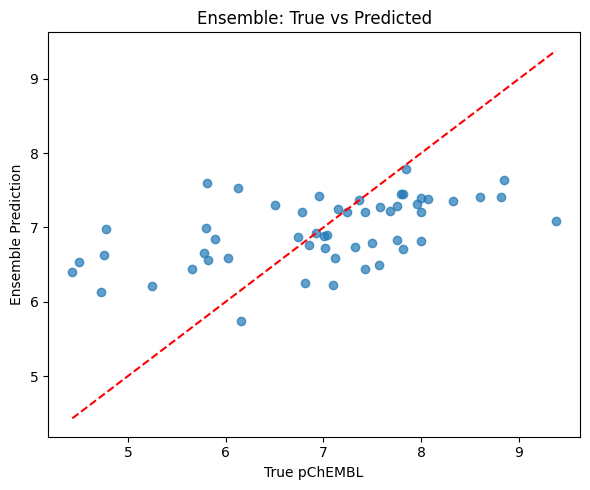

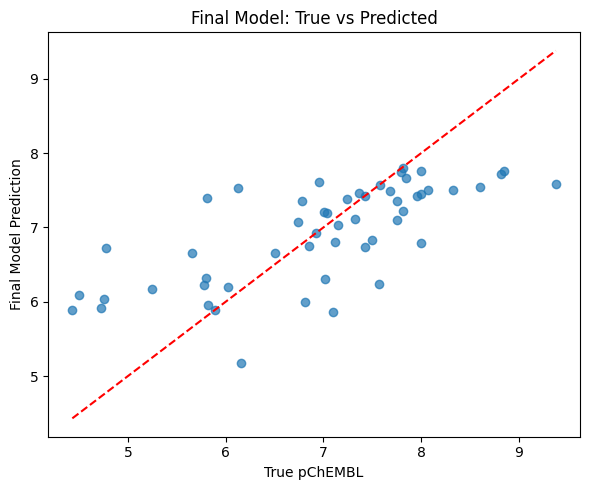

In [23]:
# Prepare ensemble metrics list
if task == "classification":
    ensemble_metrics = [acc, precision, recall, f1, auc]
else:
    ensemble_metrics = [mae, mse, rmse, r2]

# Create comparison DataFrame
comp = pd.DataFrame({
    "metric":   list(final_metrics.keys()),
    "ensemble": ensemble_metrics,
    "final":    list(final_metrics.values())
})
display(comp)


# 8) Save final model
model_path = os.path.join(results_dir, "final_model.pt")
torch.save(model.state_dict(), model_path)
print(f"✅ Final model saved to {model_path}")
#
ensemble_plot_path = os.path.join(results_dir, "ensemble_plot.png")
fig_ensemble, ax_ensemble = plt.subplots(figsize=(6, 5))
ax_ensemble.scatter(true_value, final_pred, alpha=0.7)
ax_ensemble.plot(
    [true_value.min(), true_value.max()],
    [true_value.min(), true_value.max()],
    'r--'
)
ax_ensemble.set_title("Ensemble: True vs Predicted")
ax_ensemble.set_xlabel("True pChEMBL")
ax_ensemble.set_ylabel("Ensemble Prediction")
plt.tight_layout()
fig_ensemble.savefig(ensemble_plot_path)
print(f"✅ Ensemble plot saved to {ensemble_plot_path}")

# Save final model plot
final_model_plot_path = os.path.join(results_dir, "final_model_plot.png")
fig_final, ax_final = plt.subplots(figsize=(6, 5))
ax_final.scatter(true_final, pred_final, alpha=0.7)
ax_final.plot(
    [true_final.min(), true_final.max()],
    [true_final.min(), true_final.max()],
    'r--'
)
ax_final.set_title("Final Model: True vs Predicted")
ax_final.set_xlabel("True pChEMBL")
ax_final.set_ylabel("Final Model Prediction")
plt.tight_layout()
fig_final.savefig(final_model_plot_path)
print(f"✅ Final model plot saved to {final_model_plot_path}")